In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Define Pauli matrices
I = np.array([[1, 0], [0, 1]], dtype=complex)
Z = np.array([[0, 1], [1, 0]], dtype=complex) #old X
X = np.array([[1, 0], [0, -1]], dtype=complex) #old Z

def kron_n(ops):
    """Kronecker product of a list of operators."""
    result = ops[0]
    for op in ops[1:]:
        result = np.kron(result, op)
    return result

def op_on_site(op, site, N):
    """Apply operator 'op' to 'site' (0-indexed) in N-spin system."""
    ops = [I] * N
    ops[site] = op
    return kron_n(ops)

In [14]:
print("I=:\n",np.round(I.real, 2))
print("X=:\n",np.round(X.real, 2))
print("Z=:\n",np.round(Z.real, 2))

I=:
 [[1. 0.]
 [0. 1.]]
X=:
 [[ 1.  0.]
 [ 0. -1.]]
Z=:
 [[0. 1.]
 [1. 0.]]


In [15]:
# N=2 test
print("Z on site 0 (N=2):\n", np.round(op_on_site(Z, 0, 2).real, 2))
print("Z on site 1 (N=2):\n", np.round(op_on_site(Z, 1, 2).real, 2))

# N=3 test
print("X on site 1 (N=3):\n", np.round(op_on_site(X, 1, 3).real, 2))


Z on site 0 (N=2):
 [[0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 1. 0. 0.]]
Z on site 1 (N=2):
 [[0. 1. 0. 0.]
 [1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]
X on site 1 (N=3):
 [[ 1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. -1. -0.  0.  0. -0. -0.]
 [ 0.  0. -0. -1.  0.  0. -0. -0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0. -0. -0.  0.  0. -1. -0.]
 [ 0.  0. -0. -0.  0.  0. -0. -1.]]


In [16]:
def TFIM_H(N, J=1.0, h=1.0):
    H = np.zeros((2**N, 2**N), dtype=complex)
    # Interaction terms: Z_i Z_{i+1}
    for i in range(N-1):
        H += -J * (op_on_site(Z, i, N) @ op_on_site(Z, i+1, N))
    # Field terms: X_i
    for i in range(N):
        H += -h * op_on_site(X, i, N)
    return H


Testing the eigenvalues


In [17]:
from numpy.linalg import eigh

# Build H for N=2
H2 = TFIM_H(N=2, J=1.0, h=0.0)

# Diagonalize
evals2, evecs2 = eigh(H2)

print("Hamiltonian (N=2, J=1, h=0):")
print(np.round(H2.real, 2))   # drop imaginary parts

print("\nEigenvalues:")
print(np.round(evals2.real, 2))

evals2, evecs2 = eigh(Z)
print(np.round(Z.real, 2))   # drop imaginary parts

print("\nEigenvalues:")
print(np.round(evals2.real, 2))

Hamiltonian (N=2, J=1, h=0):
[[ 0.  0.  0. -1.]
 [ 0.  0. -1.  0.]
 [ 0. -1.  0.  0.]
 [-1.  0.  0.  0.]]

Eigenvalues:
[-1. -1.  1.  1.]
[[0. 1.]
 [1. 0.]]

Eigenvalues:
[-1.  1.]


In [18]:
def Jz_Jlong_H(N, Jz=1.0, Jlong=1.0):
    H = np.zeros((2**N, 2**N), dtype=complex)

    # NN interaction in z
    for i in range(N-1):
        H += Jz * (op_on_site(Z, i, N) @ op_on_site(Z, i+1, N))

    # All-to-all long-range x coupling
    for i in range(N):
        for j in range(i+1, N):
            H += Jlong * (op_on_site(X, i, N) @ op_on_site(X, j, N))

    return H


In [19]:
# Test with N=2
H2 = Jz_Jlong_H(N=2, Jz=1.0, Jlong=1)
evals2, _ = eigh(H2)

print("Hamiltonian (N=2):\n", np.round(H2.real, 2))
print("\nEigenvalues:\n", np.round(evals2, 3))


Hamiltonian (N=2):
 [[ 1.  0.  0.  1.]
 [ 0. -1.  1.  0.]
 [ 0.  1. -1.  0.]
 [ 1.  0.  0.  1.]]

Eigenvalues:
 [-2.  0.  0.  2.]


### 1. Hamiltonian with α

We want:

$$
H = J_z \sum_{i=0}^{N-2} \sigma_i^z \sigma_{i+1}^z 
   + J_{\text{long}} \sum_{i<j} \frac{1}{|i-j|^{\alpha}} \, \sigma_i^x \sigma_j^x .
$$

- The \(J_z\) term is just **nearest neighbors** (as before).
- The \(J_{\text{long}}\) term is **long-range**, with strength decaying like \(1/|i-j|^{\alpha}\).


### 2. Kac Rescaling

Without rescaling, the sum of long-range couplings diverges as \(N\) grows (for small \(\alpha\)).  
The Kac factor normalizes the interaction strength so that the **energy per spin remains finite**:

$$
\mathcal{N}(\alpha, N) = \frac{1}{N-1} \sum_{i<j} \frac{1}{|i-j|^{\alpha}} .
$$

Then rescale:

$$
J_{\text{long}} \;\;\to\;\; \frac{J_{\text{long}}}{\mathcal{N}(\alpha, N)} .
$$


In [20]:
def kac_norm(N, alpha):
    """Kac normalization factor for power-law interactions."""
    total = 0.0
    for i in range(N):
        for j in range(i+1, N):
            total += 1.0 / (abs(i-j)**alpha if alpha != 0 else 1.0)
    return total / (N-1)


def Jz_Jlong_H_alpha(N, Jz=1.0, Jlong=1.0, alpha=0.0, kac=True):
    H = np.zeros((2**N, 2**N), dtype=complex)

    # NN interaction in z
    for i in range(N-1):
        H += Jz * (op_on_site(Z, i, N) @ op_on_site(Z, i+1, N))

    # Normalization
    if kac:
        norm = kac_norm(N, alpha)
    else:
        norm = 1.0

    # Long-range interaction in x
    for i in range(N):
        for j in range(i+1, N):
            weight = 1.0 / (abs(i-j)**alpha if alpha != 0 else 1.0)
            H += (Jlong / norm) * weight * (op_on_site(X, i, N) @ op_on_site(X, j, N))

    return H


In [21]:
def spectrum_vs_Jlong(N=3, Jz=1.0, g_values=np.linspace(0,3,50), alpha=0.0, kac=True, plot_ground=True, plot_gap=True):
    evals_all = []
    for g in g_values:
        H = Jz_Jlong_H_alpha(N=N, Jz=Jz, Jlong=g*Jz, alpha=alpha, kac=kac)
        evals, _ = eigh(H)
        evals_all.append(evals.real)
    evals_all = np.array(evals_all)

    # --- Full spectrum plot ---
    plt.figure(figsize=(6,4))
    for i in range(2**N):
        plt.plot(g_values, evals_all[:,i], lw=1)
    plt.xlabel(r"$J_{\mathrm{long}}/J_z$")
    plt.ylabel("Eigenvalues")
    plt.title(f"Spectrum vs $J_{{long}}/J_z$ (N={N}, α={alpha}, Kac={kac})")
    plt.grid(True)
    plt.show()

    # --- Ground state energy plot ---
    if plot_ground:
        plt.figure(figsize=(6,4))
        ground = evals_all.min(axis=1)
        plt.plot(g_values, ground, 'k-', lw=2, label="Ground state")
        plt.xlabel(r"$J_{\mathrm{long}}/J_z$")
        plt.ylabel("Ground state energy")
        plt.title(f"Ground state vs $J_{{long}}/J_z$ (N={N}, α={alpha})")
        plt.grid(True)
        plt.legend()
        plt.show()

    # --- Gap plot (E1 - E0) ---
    if plot_gap:
        plt.figure(figsize=(6,4))
        gaps = []
        for row in evals_all:
            sorted_vals = np.sort(row)
            gaps.append(sorted_vals[1] - sorted_vals[0])
        plt.plot(g_values, gaps, 'r-', lw=2, label="Gap (E1 - E0)")
        plt.xlabel(r"$J_{\mathrm{long}}/J_z$")
        plt.ylabel("Energy gap")
        plt.title(f"Gap vs $J_{{long}}/J_z$ (N={N}, α={alpha})")
        plt.grid(True)
        plt.legend()
        plt.show()


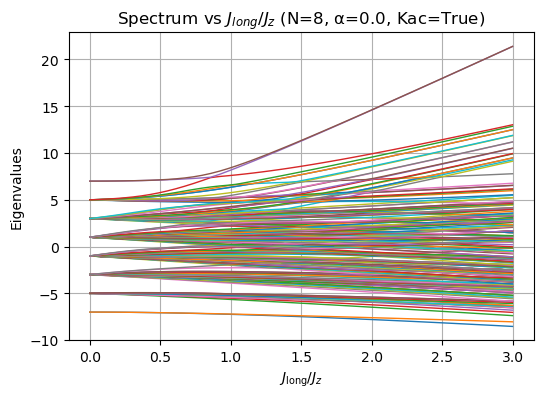

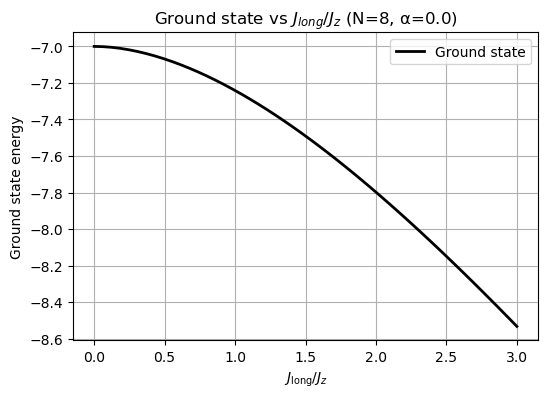

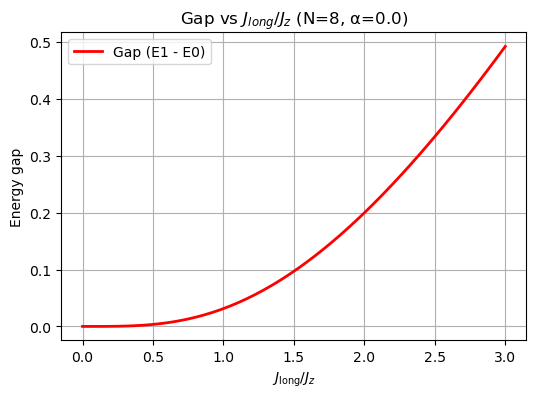

In [22]:
spectrum_vs_Jlong(N=8, Jz=1.0, g_values=np.linspace(0,3,50), alpha=0.0, kac=True)


In [7]:
def spectrum_vs_h_TFIM(N=3, J=1.0, h_values=np.linspace(0,3,50), plot_ground=True, plot_gap=True):
    evals_all = []
    for h in h_values:
        H = TFIM_H(N=N, J=J, h=h)
        evals, _ = eigh(H)
        evals_all.append(evals.real)
    evals_all = np.array(evals_all)

    # --- Full spectrum ---
    plt.figure(figsize=(6,4))
    for i in range(2**N):
        plt.plot(h_values/J, evals_all[:,i], lw=1)
    plt.xlabel(r"$h/J$")
    plt.ylabel("Eigenvalues")
    plt.title(f"TFIM Spectrum vs $h/J$ (N={N})")
    plt.grid(True)
    plt.show()

    # --- Ground state energy ---
    if plot_ground:
        ground = evals_all.min(axis=1)
        plt.figure(figsize=(6,4))
        plt.plot(h_values/J, ground, 'k-', lw=2, label="Ground state")
        plt.xlabel(r"$h/J$")
        plt.ylabel("Ground state energy")
        plt.title(f"Ground state vs $h/J$ (N={N})")
        plt.grid(True)
        plt.legend()
        plt.show()

    # --- Gap (E1 - E0) ---
    if plot_gap:
        gaps = []
        for row in evals_all:
            sorted_vals = np.sort(row)
            gaps.append(sorted_vals[1] - sorted_vals[0])
        plt.figure(figsize=(6,4))
        plt.plot(h_values/J, gaps, 'r-', lw=2, label="Gap (E1 - E0)")
        plt.xlabel(r"$h/J$")
        plt.ylabel("Gap")
        plt.title(f"Gap vs $h/J$ (N={N})")
        plt.grid(True)
        plt.legend()
        plt.show()


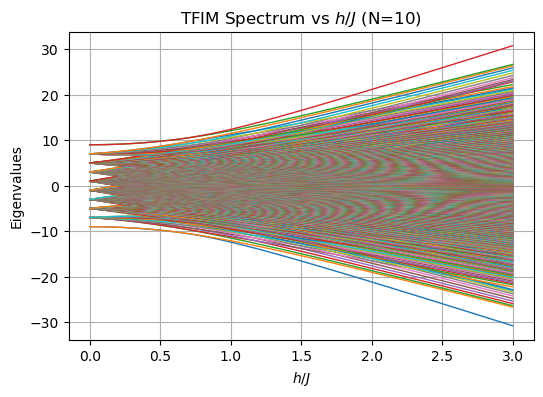

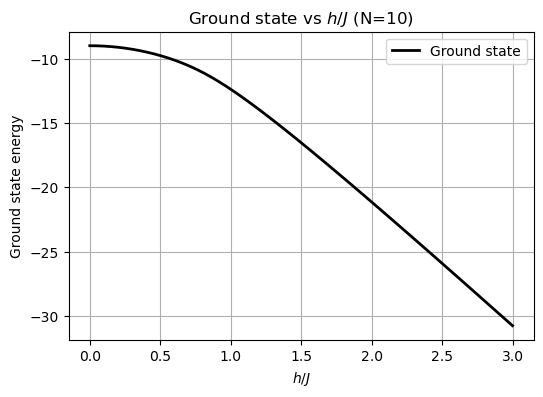

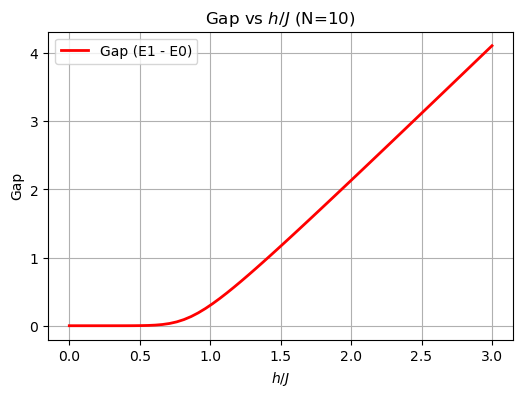

In [24]:
spectrum_vs_h_TFIM(N=10, J=1.0, h_values=np.linspace(0,3,60))


  Using cached qutip-5.2.0-cp312-cp312-win_amd64.whl.metadata (9.6 kB)
Using cached qutip-5.2.0-cp312-cp312-win_amd64.whl (10.1 MB)
